In [2]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler

# AutoEncoder Class
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim * 2),
            nn.ReLU(),
            nn.Linear(encoding_dim * 2, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, encoding_dim * 2),
            nn.ReLU(),
            nn.Linear(encoding_dim * 2, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Function to load and process time series data
def load_time_series(dirname):
    ids = os.listdir(dirname)
    stats_list = []

    for id_folder in ids:
        file_path = os.path.join(dirname, id_folder, 'part-0.parquet')
        if os.path.exists(file_path):
            df = pd.read_parquet(file_path)
            stats = df.describe().values.flatten()  # Summary stats
            stats_list.append((stats, id_folder.split('=')[1]))  # Flatten stats and extract ID

    stats_df = pd.DataFrame([x[0] for x in stats_list], columns=[f"stat_{i}" for i in range(len(stats_list[0][0]))])
    stats_df['id'] = [x[1] for x in stats_list]
    return stats_df

# Function to train autoencoder and encode data
def encode_time_series(data, encoding_dim=50, epochs=50, batch_size=32):
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data.drop('id', axis=1))  # Scale data (drop 'id' column)

    # Convert to PyTorch tensor
    data_tensor = torch.FloatTensor(data_scaled)
    input_dim = data_tensor.shape[1]

    # Initialize AutoEncoder
    autoencoder = AutoEncoder(input_dim, encoding_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

    # Training loop
    for epoch in range(epochs):
        for i in range(0, len(data_tensor), batch_size):
            batch = data_tensor[i: i + batch_size]
            optimizer.zero_grad()
            reconstructed = autoencoder(batch)
            loss = criterion(reconstructed, batch)
            loss.backward()
            optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}')

    # Encode data
    with torch.no_grad():
        encoded_data = autoencoder.encoder(data_tensor).numpy()

    # Create encoded DataFrame
    encoded_df = pd.DataFrame(encoded_data, columns=[f'Enc_{i + 1}' for i in range(encoding_dim)])
    encoded_df['id'] = data['id'].values
    return encoded_df

# Directory paths for time series data
train_dir = '/Users/samchen/Downloads/child-mind-institute-problematic-internet-use/series_train.parquet'
test_dir = '/Users/samchen/Downloads/child-mind-institute-problematic-internet-use/series_test.parquet'

# Load and process time series data
train_ts = load_time_series(train_dir)
test_ts = load_time_series(test_dir)

# Encode the time series data
train_encoded = encode_time_series(train_ts, encoding_dim=60, epochs=50, batch_size=32)
test_encoded = encode_time_series(test_ts, encoding_dim=60, epochs=50, batch_size=32)

# Combine train and test encoded data into one DataFrame
encoded_data = pd.concat([train_encoded, test_encoded], ignore_index=True)

# Output the final DataFrame
print("Encoded Time Series Data:")
print(encoded_data.head())

# # Save to CSV (optional)
# encoded_data.to_csv('/Users/samchen/Downloads/encoded_time_series.csv', index=False)


Epoch 10/50, Loss: 0.4180
Epoch 20/50, Loss: 0.4034
Epoch 30/50, Loss: 0.3929
Epoch 40/50, Loss: 0.3892
Epoch 50/50, Loss: 0.3878
Epoch 10/50, Loss: 1.0337
Epoch 20/50, Loss: 0.6957
Epoch 30/50, Loss: 0.4444
Epoch 40/50, Loss: 0.4280
Epoch 50/50, Loss: 0.4279
Encoded Time Series Data:
      Enc_1     Enc_2     Enc_3     Enc_4     Enc_5     Enc_6     Enc_7  \
0  3.289001  4.818909  3.832870  3.133467  3.277224  4.287088  1.772545   
1  4.845863  5.011546  3.153925  0.514679  2.183238  0.000000  1.474430   
2  6.387668  7.421933  4.123437  1.843994  5.516912  0.000000  2.737626   
3  1.288746  3.376593  4.015028  1.985485  0.460288  1.422737  2.686480   
4  2.797648  9.049925  3.051049  0.491708  2.627655  0.000000  2.317159   

      Enc_8     Enc_9    Enc_10  ...    Enc_52    Enc_53    Enc_54    Enc_55  \
0  3.284067  7.931957  5.326877  ...  0.000000  5.441700  0.323357  0.000000   
1  3.479956  0.000000  3.051737  ...  5.053469  1.492751  1.335125  0.000000   
2  9.787134  0.000000  

In [19]:
# Function to display columns of the first Parquet file in the directory
def show_parquet_columns(dirname):
    ids = os.listdir(dirname)
    for id_folder in ids:
        file_path = os.path.join(dirname, id_folder, 'part-0.parquet')
        if os.path.exists(file_path):
            df = pd.read_parquet(file_path)
            print(f"Columns in the first Parquet file ({file_path}):")
            print(df.columns.tolist())
            return df  # Return the DataFrame if needed for further inspection
    print("No Parquet file found in the specified directory.")
    return None

# Directory path for the data
train_dir = '/Users/samchen/Downloads/child-mind-institute-problematic-internet-use/series_train.parquet'

# Show columns of the first Parquet file
first_df = show_parquet_columns(train_dir)

# Optional: Display the first few rows of the DataFrame
if first_df is not None:
    print("\nFirst few rows of the Parquet file:")
    print(first_df.head())


Columns in the first Parquet file (/Users/samchen/Downloads/child-mind-institute-problematic-internet-use/series_train.parquet/id=0d01bbf2/part-0.parquet):
['step', 'X', 'Y', 'Z', 'enmo', 'anglez', 'non-wear_flag', 'light', 'battery_voltage', 'time_of_day', 'weekday', 'quarter', 'relative_date_PCIAT']

First few rows of the Parquet file:
   step         X         Y         Z      enmo     anglez  non-wear_flag  \
0     0 -0.468869  0.412020 -0.236458  0.042506 -19.824650            0.0   
1     1 -0.662526  0.533484  0.064034  0.052847   4.300246            0.0   
2     2 -0.611384  0.227252 -0.150882  0.060734 -16.545208            0.0   
3     3 -0.385799  0.552782 -0.500523  0.070440 -36.452175            0.0   
4     4  0.016133  0.031981 -0.825109  0.081058 -67.488388            0.0   

       light  battery_voltage     time_of_day  weekday  quarter  \
0  27.666666      4179.000000  57480000000000        4        1   
1  12.666667      4178.666504  57485000000000        4        1

In [3]:
# Step 1: Initialize AutoEncoder
input_dim = train_ts.drop('id', axis=1).shape[1]
autoencoder = AutoEncoder(input_dim=input_dim, encoding_dim=50)

# Step 2: Train AutoEncoder
scaler = StandardScaler()
data_scaled = scaler.fit_transform(train_ts.drop('id', axis=1))  # Scale data (drop 'id' column)
data_tensor = torch.FloatTensor(data_scaled)  # Convert to PyTorch tensor

criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
epochs = 50
batch_size = 32

# Train the AutoEncoder
for epoch in range(epochs):
    for i in range(0, len(data_tensor), batch_size):
        batch = data_tensor[i: i + batch_size]
        optimizer.zero_grad()
        reconstructed = autoencoder(batch)
        loss = criterion(reconstructed, batch)
        loss.backward()
        optimizer.step()

# Step 3: Compute Reconstruction Error
with torch.no_grad():
    reconstructed = autoencoder(data_tensor)
reconstruction_error = ((reconstructed - data_tensor) ** 2).mean(axis=1)

# Step 4: Identify Anomalies
threshold = reconstruction_error.mean() - 0.5 * reconstruction_error.std()  # Set anomaly threshold
anomalies = reconstruction_error < threshold  # Boolean mask for anomalies

# Step 5: Extract IDs of Anomalies
anomalous_ids = train_ts.loc[anomalies.numpy(), 'id']  # Use mask to filter IDs
print(f"Number of anomalies detected: {len(anomalous_ids)}")
print("Anomalous IDs:")
print(anomalous_ids)

# # Optional: Save anomalous IDs to a CSV
# anomalous_ids.to_csv('anomalous_ids.csv', index=False)


Number of anomalies detected: 215
Anomalous IDs:
1      cefdb7fe
16     bebff291
26     cd68643b
27     af4f064e
35     1837456f
         ...   
973    350dbeba
981    9b96b0e4
984    214f46e8
987    c731458f
995    57de6095
Name: id, Length: 215, dtype: object


In [4]:
import pandas as pd

path = '/Users/samchen/Downloads/child-mind-institute-problematic-internet-use/train.csv'

df = pd.read_csv(path)

sii_df = df[['id','sii']]

# Convert anomalous_ids to a DataFrame if it's a Series
if isinstance(anomalous_ids, pd.Series):
    anomalous_ids = anomalous_ids.to_frame(name='id')

# Perform an inner join to find the cross-section
matched_df = pd.merge(anomalous_ids, sii_df, how='inner', on='id')

# Print the results
print("Matched IDs with SII:")
print(matched_df[matched_df['sii'] > 0])


Matched IDs with SII:
           id  sii
0    cefdb7fe  1.0
6    8c1f9196  1.0
8    8a77c3e9  1.0
11   1f65fa82  1.0
12   c79039af  1.0
..        ...  ...
204  a26c3e8f  1.0
208  9bdd6964  1.0
209  a2994e55  2.0
212  214f46e8  1.0
213  c731458f  1.0

[84 rows x 2 columns]


## TSNE Visualization?

Epoch 10/50, Loss: 0.4269
Epoch 20/50, Loss: 0.3952
Epoch 30/50, Loss: 0.3893
Epoch 40/50, Loss: 0.3885
Epoch 50/50, Loss: 0.3861
Epoch 10/50, Loss: 1.0323
Epoch 20/50, Loss: 0.6978
Epoch 30/50, Loss: 0.4434
Epoch 40/50, Loss: 0.4281
Epoch 50/50, Loss: 0.4279
Performing t-SNE on Encoded Data...
Cluster Counts:
0    658
1    340
Name: cluster, dtype: int64


/Users/samchen/Library/Python/3.8/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


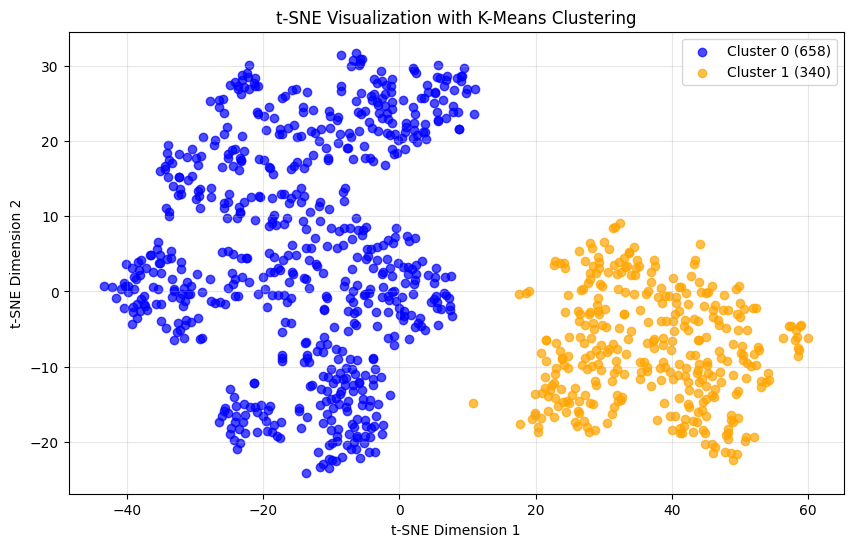

t-SNE results with clusters saved to tsne_results_with_clusters.csv


In [5]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assume AutoEncoder, load_time_series, and encode_time_series are already defined as in your provided code

# Directory paths for time series data
train_dir = '/Users/samchen/Downloads/child-mind-institute-problematic-internet-use/series_train.parquet'
test_dir = '/Users/samchen/Downloads/child-mind-institute-problematic-internet-use/series_test.parquet'

# Load and process time series data
train_ts = load_time_series(train_dir)
test_ts = load_time_series(test_dir)

# Encode the time series data
train_encoded = encode_time_series(train_ts, encoding_dim=60, epochs=50, batch_size=32)
test_encoded = encode_time_series(test_ts, encoding_dim=60, epochs=50, batch_size=32)

# Combine train and test encoded data into one DataFrame
encoded_data = pd.concat([train_encoded, test_encoded], ignore_index=True)

# Perform t-SNE
print("Performing t-SNE on Encoded Data...")
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(encoded_data.drop('id', axis=1))

# Add t-SNE results back to DataFrame
encoded_data['tSNE_1'] = tsne_results[:, 0]
encoded_data['tSNE_2'] = tsne_results[:, 1]

# Perform K-Means Clustering on t-SNE results
kmeans = KMeans(n_clusters=2, random_state=42)
encoded_data['cluster'] = kmeans.fit_predict(tsne_results)

# Count points in each cluster
cluster_counts = encoded_data['cluster'].value_counts()
print("Cluster Counts:")
print(cluster_counts)

# Visualize t-SNE Results with K-Means Clusters
plt.figure(figsize=(10, 6))
for cluster, color in zip(cluster_counts.index, ['blue', 'orange']):
    cluster_data = encoded_data[encoded_data['cluster'] == cluster]
    plt.scatter(cluster_data['tSNE_1'], cluster_data['tSNE_2'], label=f"Cluster {cluster} ({cluster_counts[cluster]})", alpha=0.7, color=color)

plt.title("t-SNE Visualization with K-Means Clustering")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Save t-SNE results with cluster labels (optional)
encoded_data[['id', 'cluster', 'tSNE_1', 'tSNE_2']].to_csv('/Users/samchen/Downloads/tsne_results_with_clusters.csv', index=False)
print("t-SNE results with clusters saved to tsne_results_with_clusters.csv")


Training with encoding_dim=20, batch_size=16, learning_rate=0.001...
Reconstruction Loss: 0.6831
Training with encoding_dim=20, batch_size=16, learning_rate=0.01...
Reconstruction Loss: 0.6973
Training with encoding_dim=20, batch_size=32, learning_rate=0.001...
Reconstruction Loss: 0.6855
Training with encoding_dim=20, batch_size=32, learning_rate=0.01...
Reconstruction Loss: 0.6717
Training with encoding_dim=20, batch_size=64, learning_rate=0.001...
Reconstruction Loss: 0.7066
Training with encoding_dim=20, batch_size=64, learning_rate=0.01...
Reconstruction Loss: 0.6804
Training with encoding_dim=40, batch_size=16, learning_rate=0.001...
Reconstruction Loss: 0.6594
Training with encoding_dim=40, batch_size=16, learning_rate=0.01...
Reconstruction Loss: 0.7211
Training with encoding_dim=40, batch_size=32, learning_rate=0.001...
Reconstruction Loss: 0.6693
Training with encoding_dim=40, batch_size=32, learning_rate=0.01...
Reconstruction Loss: 0.6799
Training with encoding_dim=40, batc

/Users/samchen/Library/Python/3.8/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


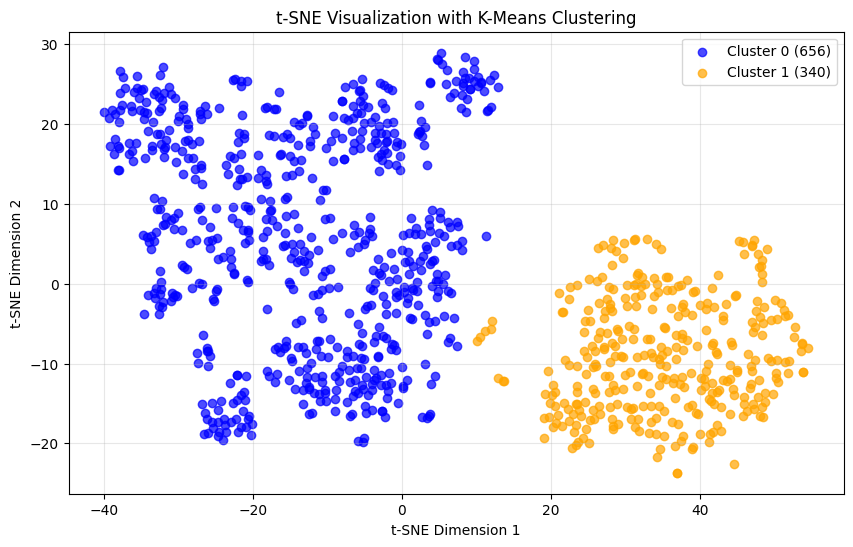

In [6]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from itertools import product

# Directory paths for time series data
train_dir = '/Users/samchen/Downloads/child-mind-institute-problematic-internet-use/series_train.parquet'

# AutoEncoder Class
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim * 2),
            nn.ReLU(),
            nn.Linear(encoding_dim * 2, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, encoding_dim * 2),
            nn.ReLU(),
            nn.Linear(encoding_dim * 2, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Function to train autoencoder and compute reconstruction loss
def train_autoencoder(data, encoding_dim, batch_size, learning_rate, epochs):
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data.drop('id', axis=1))  # Scale data
    data_tensor = torch.FloatTensor(data_scaled)
    input_dim = data_tensor.shape[1]

    # Initialize AutoEncoder
    autoencoder = AutoEncoder(input_dim, encoding_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(epochs):
        for i in range(0, len(data_tensor), batch_size):
            batch = data_tensor[i: i + batch_size]
            optimizer.zero_grad()
            reconstructed = autoencoder(batch)
            loss = criterion(reconstructed, batch)
            loss.backward()
            optimizer.step()

    # Compute reconstruction loss on the entire dataset
    with torch.no_grad():
        reconstructed = autoencoder(data_tensor)
        reconstruction_loss = criterion(reconstructed, data_tensor).item()

    return autoencoder, reconstruction_loss

# Grid Search
def grid_search(data, encoding_dims, batch_sizes, learning_rates, epochs):
    results = []

    for encoding_dim, batch_size, learning_rate in product(encoding_dims, batch_sizes, learning_rates):
        print(f"Training with encoding_dim={encoding_dim}, batch_size={batch_size}, learning_rate={learning_rate}...")
        autoencoder, loss = train_autoencoder(data, encoding_dim, batch_size, learning_rate, epochs)
        print(f"Reconstruction Loss: {loss:.4f}")
        
        # Store results
        results.append({
            'encoding_dim': encoding_dim,
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'reconstruction_loss': loss,
            'autoencoder': autoencoder  # Store the model for later use
        })

    return pd.DataFrame(results)

# Load and process time series data
def load_time_series(dirname):
    ids = os.listdir(dirname)
    stats_list = []

    for id_folder in ids:
        file_path = os.path.join(dirname, id_folder, 'part-0.parquet')
        if os.path.exists(file_path):
            df = pd.read_parquet(file_path)
            stats = df.describe().values.flatten()  # Summary stats
            stats_list.append((stats, id_folder.split('=')[1]))  # Flatten stats and extract ID

    stats_df = pd.DataFrame([x[0] for x in stats_list], columns=[f"stat_{i}" for i in range(len(stats_list[0][0]))])
    stats_df['id'] = [x[1] for x in stats_list]
    return stats_df

# Perform t-SNE and Clustering
def tsne_and_clustering(autoencoder, data, encoding_dim):
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data.drop('id', axis=1))
    data_tensor = torch.FloatTensor(data_scaled)

    with torch.no_grad():
        encoded_data = autoencoder.encoder(data_tensor).numpy()

    # Perform t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(encoded_data)

    # Perform K-Means Clustering
    kmeans = KMeans(n_clusters=2, random_state=42)
    clusters = kmeans.fit_predict(tsne_results)

    # Add results to a DataFrame
    encoded_df = pd.DataFrame(encoded_data, columns=[f'Enc_{i + 1}' for i in range(encoding_dim)])
    encoded_df['tSNE_1'] = tsne_results[:, 0]
    encoded_df['tSNE_2'] = tsne_results[:, 1]
    encoded_df['cluster'] = clusters
    encoded_df['id'] = data['id'].values

    # Plot t-SNE results with clusters
    cluster_counts = encoded_df['cluster'].value_counts()
    plt.figure(figsize=(10, 6))
    for cluster, color in zip(cluster_counts.index, ['blue', 'orange']):
        cluster_data = encoded_df[encoded_df['cluster'] == cluster]
        plt.scatter(cluster_data['tSNE_1'], cluster_data['tSNE_2'], label=f"Cluster {cluster} ({cluster_counts[cluster]})", alpha=0.7, color=color)

    plt.title("t-SNE Visualization with K-Means Clustering")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    return encoded_df

# Hyperparameter ranges
encoding_dims = [20, 40, 60]
batch_sizes = [16, 32, 64]
learning_rates = [0.001, 0.01]
epochs = 50

# Perform Grid Search
train_ts = load_time_series(train_dir)
results_df = grid_search(train_ts, encoding_dims, batch_sizes, learning_rates, epochs)

# Select the best model
best_result = results_df.loc[results_df['reconstruction_loss'].idxmin()]
best_autoencoder = best_result['autoencoder']

# Perform t-SNE and Clustering on the best autoencoder
print("Performing t-SNE and Clustering on the Best Model...")
encoded_df = tsne_and_clustering(best_autoencoder, train_ts, best_result['encoding_dim'])

# Save Results
encoded_df.to_csv('/Users/samchen/Downloads/tsne_results_with_clusters.csv', index=False)
results_df.to_csv('/Users/samchen/Downloads/grid_search_results.csv', index=False)


Performing t-SNE and Spectral Clustering on the Best Model...


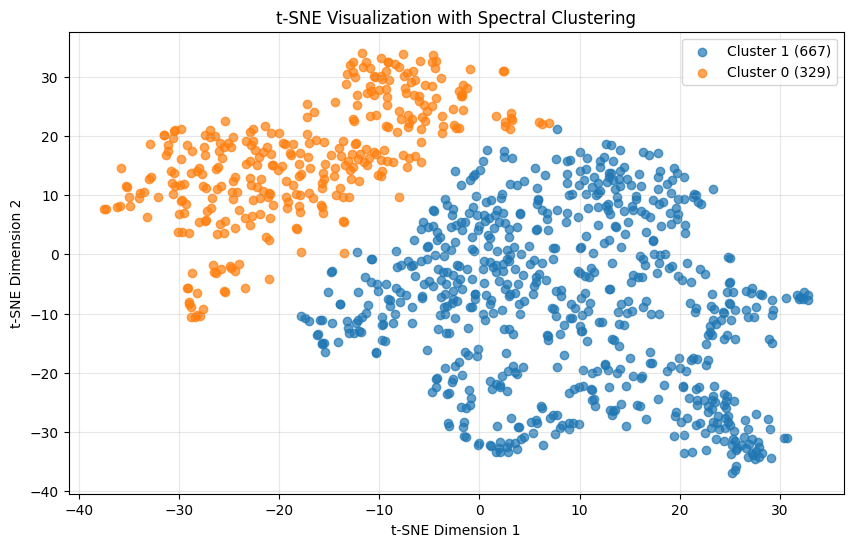

In [33]:
from sklearn.cluster import SpectralClustering

# Perform t-SNE and Spectral Clustering
def tsne_and_spectral_clustering(autoencoder, data, encoding_dim, n_clusters=2):
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data.drop('id', axis=1))
    data_tensor = torch.FloatTensor(data_scaled)

    # Encode the data using the autoencoder
    with torch.no_grad():
        encoded_data = autoencoder.encoder(data_tensor).numpy()

    # Perform t-SNE for dimensionality reduction
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(encoded_data)

    # Perform Spectral Clustering
    spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
    spectral_clusters = spectral.fit_predict(tsne_results)

    # Add results to a DataFrame
    encoded_df = pd.DataFrame(encoded_data, columns=[f'Enc_{i + 1}' for i in range(encoding_dim)])
    encoded_df['tSNE_1'] = tsne_results[:, 0]
    encoded_df['tSNE_2'] = tsne_results[:, 1]
    encoded_df['cluster'] = spectral_clusters
    encoded_df['id'] = data['id'].values

    # Plot t-SNE results with Spectral Clustering
    cluster_counts = encoded_df['cluster'].value_counts()
    plt.figure(figsize=(10, 6))
    for cluster in cluster_counts.index:
        cluster_data = encoded_df[encoded_df['cluster'] == cluster]
        plt.scatter(cluster_data['tSNE_1'], cluster_data['tSNE_2'], label=f"Cluster {cluster} ({cluster_counts[cluster]})", alpha=0.7)

    plt.title("t-SNE Visualization with Spectral Clustering")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    return encoded_df

# Perform t-SNE and Spectral Clustering on the best autoencoder
print("Performing t-SNE and Spectral Clustering on the Best Model...")
encoded_df_spectral = tsne_and_spectral_clustering(best_autoencoder, train_ts, best_result['encoding_dim'])

encoded_df_spectral.drop(columns = ['cluster'])

# Save Spectral Clustering Results
encoded_df_spectral.to_csv('/Users/samchen/Downloads/tsne_results_with_spectral_clusters.csv', index=False)


In [30]:
# Filter the DataFrame for Cluster 1
cluster_1_ids = encoded_df[encoded_df['cluster'] == 1]['id']
cluster_0_ids = encoded_df[encoded_df['cluster'] == 0]['id']

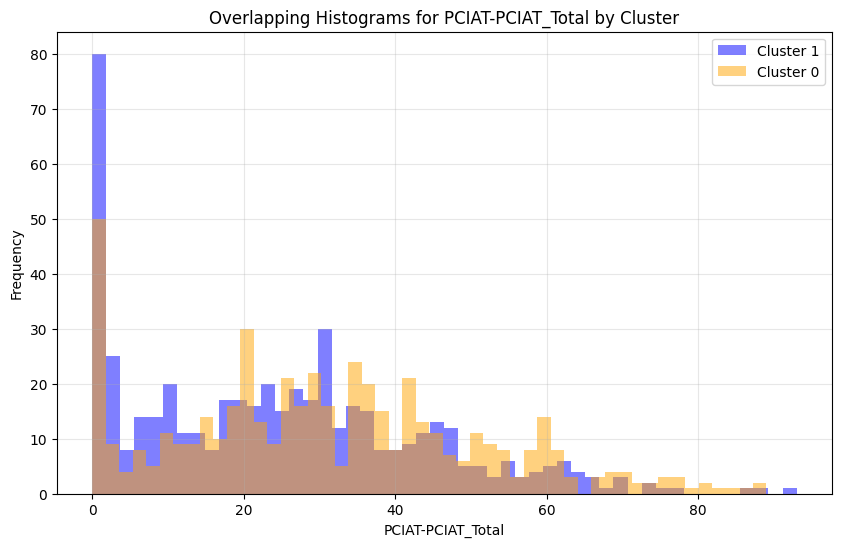

In [35]:
import matplotlib.pyplot as plt

train_data = pd.read_csv('/Users/samchen/Downloads/child-mind-institute-problematic-internet-use/train.csv')

# train_data[train_data['id'].isin(cluster_1_ids)]['sii'].plot(kind = 'hist')


# Plot histograms for both clusters on the same plot
plt.figure(figsize=(10, 6))
train_data[train_data['id'].isin(cluster_1_ids)]['PCIAT-PCIAT_Total'].plot(
    kind='hist', alpha=0.5, label='Cluster 1', bins=50, color='blue'
)
train_data[train_data['id'].isin(cluster_0_ids)]['PCIAT-PCIAT_Total'].plot(
    kind='hist', alpha=0.5, label='Cluster 0', bins=50, color='orange'
)

# Add title and labels
plt.title("Overlapping Histograms for PCIAT-PCIAT_Total by Cluster")
plt.xlabel("PCIAT-PCIAT_Total")
plt.ylabel("Frequency")
plt.legend()
plt.grid(alpha=0.3)

# Show the plot
plt.show()



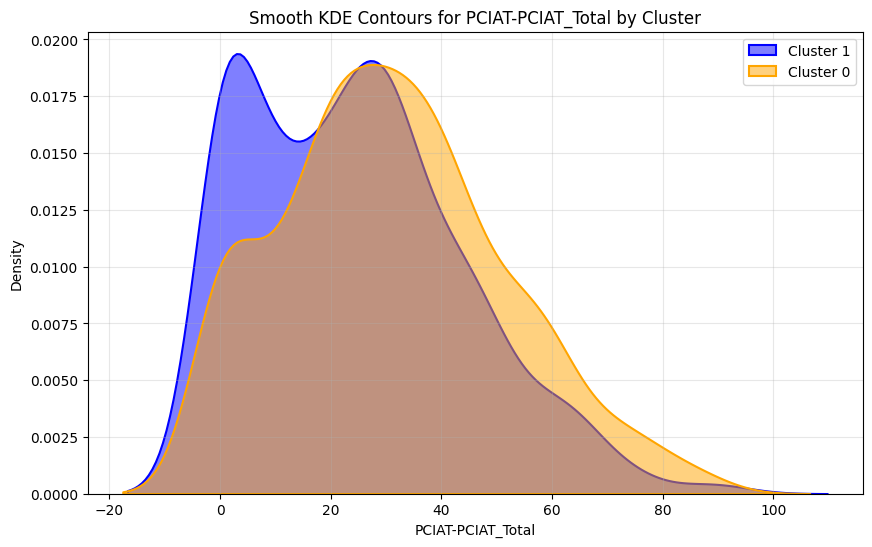

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load train data
train_data = pd.read_csv('/Users/samchen/Downloads/child-mind-institute-problematic-internet-use/train.csv')

# Filter data by clusters
cluster_1_data = train_data[train_data['id'].isin(cluster_1_ids)]['PCIAT-PCIAT_Total']
cluster_0_data = train_data[train_data['id'].isin(cluster_0_ids)]['PCIAT-PCIAT_Total']

# Create a figure
plt.figure(figsize=(10, 6))

# KDE Plot for Cluster 1
sns.kdeplot(
    cluster_1_data, 
    fill=True, 
    label='Cluster 1', 
    color='blue', 
    alpha=0.5, 
    linewidth=1.5
)

# KDE Plot for Cluster 0
sns.kdeplot(
    cluster_0_data, 
    fill=True, 
    label='Cluster 0', 
    color='orange', 
    alpha=0.5, 
    linewidth=1.5
)

# Add title and labels
plt.title("Smooth KDE Contours for PCIAT-PCIAT_Total by Cluster")
plt.xlabel("PCIAT-PCIAT_Total")
plt.ylabel("Density")
plt.legend()
plt.grid(alpha=0.3)

# Show the plot
plt.show()
